In [1]:
import os
import pandas as pd
import requests
from zipfile import ZipFile
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split, GridSearchCV
from surprise import accuracy
import matplotlib.pyplot as plt
import seaborn as sns

# Check if the 'data' directory exists, and create it if not
data_dir = '/Users/naveenverma/Desktop/NewStart/data'
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# Define the URL for the Last.fm dataset ZIP file
dataset_url = "http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip"
zip_filename = "data/hetrec2011-lastfm-2k.zip"

# Download the ZIP file and save it to the 'data' directory
if not os.path.exists(zip_filename):
    response = requests.get(dataset_url)
    with open(zip_filename, 'wb') as file:
        file.write(response.content)

# Unzip the dataset file into the 'data' directory
with ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [2]:
# Load ratings data into a Pandas DataFrame
ratings_filename = os.path.join(data_dir, "user_artists.dat")
ratings = pd.read_csv(ratings_filename, sep='\t')
ratings.columns = ["user_id", "artist_id", "rating"]

# Load artist names and genre
artists_filename = os.path.join(data_dir, "artists.dat")
artists = pd.read_csv(artists_filename, sep='\t')
artists.columns = ["artist_id", "name", "url", "picture_url"]

# Convert artist_id and user_id to strings
ratings["user_id"] = ratings["user_id"].astype(str)
ratings["artist_id"] = ratings["artist_id"].astype(str)
artists["artist_id"] = artists["artist_id"].astype(str)

# Set the 'artist_id' column as the key for the 'artists' DataFrame
artists.set_index("artist_id", inplace=True)

In [3]:
# Create a Surprise dataset from the ratings DataFrame
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['user_id', 'artist_id', 'rating']], reader)

# Split the dataset into a train set and a test set
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
# Build and train a user-based k-NN collaborative filtering model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

# Use GridSearchCV for hyperparameter tuning
param_grid = {
    'k': [20, 40, 60],
    'min_k': [1, 5, 10],
}

In [4]:
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
grid_search.fit(data)

# Get the best model from the grid search
best_model = grid_search.best_estimator['rmse']

# Train the best model on the entire training set
best_model.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

In [12]:
# Get recommendations for a specific user (e.g., user_id='18')
user_id = '1998'
top_n = best_model.get_neighbors(trainset.to_inner_uid(user_id), k=10)

recommended_artists = [artists.loc[trainset.to_raw_uid(inner_id)]['name'] for inner_id in top_n]
print(f"Top 10 Recommended Artists for User {user_id}:")
for rank, artist in enumerate(recommended_artists, 1):
    print(f"{rank}. {artist}")

# Evaluate the best model on the test set
test_predictions = best_model.test(testset)

Top 10 Recommended Artists for User 1998:
1. Bloc Party
2. New Model Army
3. The Strokes
4. Nina Simone
5. Rhydian
6. Blind Melon
7. NEWS
8. Future Pop Stars United
9. Tool
10. Neuroticfish


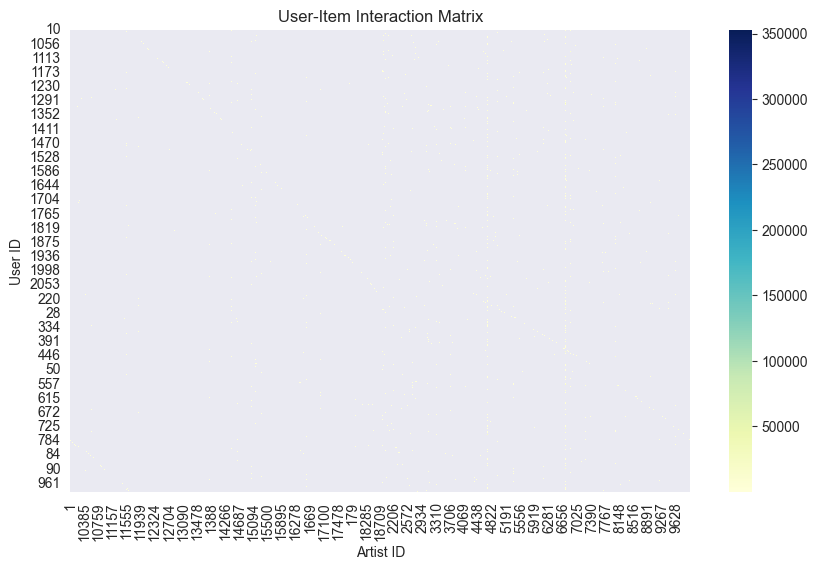

In [6]:
# Create a user-item interaction matrix from the ratings DataFrame
interaction_matrix = ratings.pivot(index='user_id', columns='artist_id', values='rating')

# Create a heatmap to visualize the interaction matrix
plt.figure(figsize=(10, 6))
sns.heatmap(interaction_matrix, cmap="YlGnBu", annot=False, cbar=bool)
plt.title('User-Item Interaction Matrix')
plt.xlabel('Artist ID')
plt.ylabel('User ID')
plt.show()

In [7]:
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
from surprise.model_selection import cross_validate

# Build and train a user-based k-NN collaborative filtering model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)
model.fit(trainset)

# Make predictions on the test set
test_predictions = model.test(testset)

# Extract true ratings and predicted ratings
true_ratings = [pred.r_ui for pred in test_predictions]
predicted_ratings = [pred.est for pred in test_predictions]

# Set a threshold to classify positive and negative ratings
threshold = 3.5
binary_true_ratings = [1 if true_rating >= threshold else 0 for true_rating in true_ratings]
binary_predicted_ratings = [1 if predicted_rating >= threshold else 0 for predicted_rating in predicted_ratings]

# Calculate precision and recall
precision = precision_score(binary_true_ratings, binary_predicted_ratings)
recall = recall_score(binary_true_ratings, binary_predicted_ratings)

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Precision: 0.9846294898069248
Recall: 0.998687161533833


In [8]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(binary_true_ratings, predicted_ratings)
roc_auc = auc(fpr, tpr)

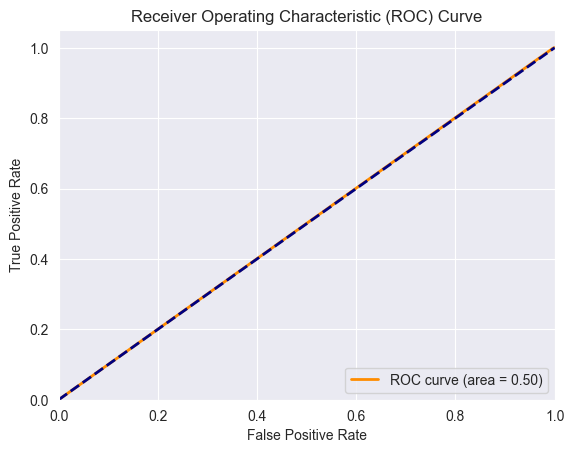

In [9]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

As our ROC curve is showing that it have a value 0.5 which means that it does not matter what we will predict out of our data because predicting at random is as good as this outcome.